## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
#William Newton
#Full-Time Online Student
#Instructor: Amber Yandow
#Review Date:
#Blog Post URL: 

# Importing Packages#

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches

# Importing 'The Numbers' Data and Cleaning#

- removed commas and dollar signs for production budget, domestic gross, and world wide gross
- converted columns to float
- changed release_date col to datetime format

In [3]:
df_bud = pd.read_csv('data/tn.movie_budgets.csv')
df_bud['production_budget'] = df_bud['production_budget'].apply(lambda x: x.replace(',',''))
df_bud['production_budget'] = df_bud['production_budget'].apply(lambda x: x.replace('$', ''))
df_bud['domestic_gross'] = df_bud['domestic_gross'].apply(lambda x: x.replace (',', ''))
df_bud['domestic_gross'] = df_bud['domestic_gross'].apply(lambda x: x.replace('$', ''))
df_bud['worldwide_gross'] = df_bud['worldwide_gross'].apply(lambda x: x.replace (',', ''))
df_bud['worldwide_gross'] = df_bud['worldwide_gross'].apply(lambda x: x.replace ('$', ''))
df_bud = df_bud.astype({'production_budget' : 'float64', 'domestic_gross' : 'float64', 'worldwide_gross' : 'float64'})
df_bud['release_date'] = pd.to_datetime(df_bud['release_date'])
df_bud.sort_values('worldwide_gross', ascending = False, inplace = True)
df_bud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 0 to 4068
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null datetime64[ns]
movie                5782 non-null object
production_budget    5782 non-null float64
domestic_gross       5782 non-null float64
worldwide_gross      5782 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 316.2+ KB


- added foreign gross column

In [4]:
df_bud['foreign_gross'] = (df_bud['worldwide_gross'] - df_bud['domestic_gross'])
top_movies_df = df_bud

- identify which rows in the data frame are missing box office numbers and production budget numbers
- decided to drop the 367 rows of data from the top_movies_df that have no data in the box office numbers columns (accounted for 6 percent of total data)

In [5]:
top_movies_df.loc[(top_movies_df['domestic_gross'] == 0) & (top_movies_df['worldwide_gross'] == 0) & (top_movies_df['foreign_gross'] == 0)].sort_values('release_date', ascending = False)
indexnames = top_movies_df[(top_movies_df['domestic_gross'] == 0) & (top_movies_df['worldwide_gross'] == 0) & (top_movies_df['foreign_gross'] == 0)].index
top_movies_df.drop(indexnames, inplace = True)

- narrowed down dataset to movies released in the last 20 years, because recent box office history is more relevant to Microsoft's question than movies release in the last century

In [6]:
top_movies_df = top_movies_df.loc[(top_movies_df['release_date'] > '2000-01-01')].sort_values('release_date')

- rename movie title column to merge with imdb data

In [7]:
top_movies_df.rename(columns = {'movie' : 'title'}, inplace = True)
top_movies_df.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross
3994,95,2000-01-12,My Dog Skip,7000000.0,34099640.0,35795319.0,1695679.0
3752,53,2000-01-12,Next Friday,9500000.0,57176582.0,59675307.0,2498725.0
940,41,2000-01-14,Supernova,60000000.0,14218868.0,14816494.0,597626.0
5747,48,2000-01-14,The Terrorist,25000.0,195043.0,195043.0,0.0
3780,81,2000-01-21,Down to You,9000000.0,20035310.0,20035310.0,0.0


# Importing 'IMDB' Data and Cleaning#

- IMDB data provided was out of date and full of NaN values so I downloaded update verisons from https://datasets.imdbws.com/
- sliced out US movie info from updated datasets (Microsoft is a US company and will be most interested in making US movies)
- combined imdb data to one dataframe

In [8]:
imdb1 = pd.read_csv('/Users/will4856/ProjectDataFolder/title.basics_updated.tsv', sep = '\t')
imdb2 = pd.read_csv('/Users/will4856/ProjectDataFolder/title.akas_updated.tsv', sep = '\t')
imdb2 = imdb2.loc[imdb2['region'] == 'US']
imdb_merge = imdb2.merge(imdb1, left_on = 'titleId', right_on = 'tconst')
imdb_merge = imdb_merge.loc[imdb_merge['titleType'] == 'movie']
imdb_merge.replace(to_replace='\\N', value='0', inplace=True)
imdb_merge = imdb_merge.astype({'startYear':'int64'})
imdb_merge = imdb_merge.loc[imdb_merge.startYear != 0]
imdb_merge = imdb_merge.loc[(imdb_merge.startYear <2020)&(imdb_merge.startYear > 1999) ]
imdb_merge=imdb_merge.sort_values(['title', 'ordering', 'runtimeMinutes'], ascending = False)

/Users/will4856/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/will4856/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merging 'The Numbers' Data and IMDB Data#

In [9]:
top_movies = top_movies_df.merge(imdb_merge, how = 'left', on='title').sort_values(['runtimeMinutes'], ascending = False)

# Cleaning Combined Data Frame#

- Removed duplicate titles and NaN values
- replaced runtime minutes values of 0 to the median value
- drop rows w/ NaN values

In [10]:
top_movies['runtimeMinutes'].replace('\\N', '0', inplace = True)
top_movies['runtimeMinutes'].fillna('0', inplace = True)
top_movies = top_movies.astype({'runtimeMinutes' : 'int64'})
top_movies=top_movies.sort_values(['title', 'runtimeMinutes'])
top_movies = top_movies.dropna()

In [11]:
top_movies.drop(['ordering', 'region', 'isOriginalTitle', 'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear'], axis = 1, inplace = True)
top_movies.drop(['language', 'types', 'attributes'], axis = 1, inplace = True)

In [12]:
top_movies['runtimeMinutes'].apply(['mean', 'std', 'median'])

mean       99.476508
std        28.879801
median    100.000000
Name: runtimeMinutes, dtype: float64

In [13]:
top_movies['runtimeMinutes'].replace(to_replace = 0, value = 102).apply(['mean', 'std', 'median'])

mean      103.198426
std        21.430113
median    102.000000
Name: runtimeMinutes, dtype: float64

In [14]:
top_movies['runtimeMinutes'].replace(to_replace = 0, value = 103.549558, inplace = True)

In [15]:
top_movies = top_movies.drop_duplicates('title', keep = 'first')

- split genre column to separate columns 

In [16]:
top_movies['genres'] = top_movies['genres'].apply(lambda x: x.replace (',', ', '))
top_movies.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,genres
4360,54,2016-03-11,10 Cloverfield Lane,5000000.0,72082999.0,108286422.0,36203423.0,tt1179933,103.0,"Drama, Horror, Mystery"
4250,48,2015-11-11,10 Days in a Madhouse,12000000.0,14616.0,14616.0,0.0,tt3453052,111.0,Drama
202,6,2000-11-22,102 Dalmatians,85000000.0,66941559.0,66941559.0,0.0,tt0211181,100.0,"Adventure, Comedy, Family"
1613,32,2006-08-18,10th & Wolf,8000000.0,54702.0,143782.0,89080.0,tt0360323,107.0,"Crime, Drama, Thriller"
2332,37,2009-03-27,12 Rounds,20000000.0,12234694.0,17306648.0,5071954.0,tt1160368,108.0,"Action, Crime, Thriller"


# Import IMDB Crew Data and Merge w/ Combined DF

- add updated crew basics dataset from IMDB and merged with top_movies df

In [17]:
imdb3 = pd.read_csv('/Users/will4856/ProjectDataFolder/title.crew_updated.tsv', sep = '\t')
imdb3.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [18]:
top_movies = top_movies.merge(imdb3, left_on = 'titleId', right_on = 'tconst')

# Import IMDB Name Data/Cleaning/Merge w/ Combined DF#

- import update IMDB name data
- prepare top_movies df for merging

In [19]:
imdb_names = pd.read_csv('/Users/will4856/ProjectDataFolder/name.basics_updated.tsv', sep = '\t')

In [20]:
top_movies = top_movies.sort_values('worldwide_gross', ascending = False)
top_movies = top_movies.drop_duplicates('titleId')
top_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3152 entries, 247 to 172
Data columns (total 13 columns):
id                   3152 non-null int64
release_date         3152 non-null datetime64[ns]
title                3152 non-null object
production_budget    3152 non-null float64
domestic_gross       3152 non-null float64
worldwide_gross      3152 non-null float64
foreign_gross        3152 non-null float64
titleId              3152 non-null object
runtimeMinutes       3152 non-null float64
genres               3152 non-null object
tconst               3152 non-null object
directors            3152 non-null object
writers              3152 non-null object
dtypes: datetime64[ns](1), float64(5), int64(1), object(6)
memory usage: 344.8+ KB


- split genre results into separate columns and dropped original columns, kept genre count at 2 to avoid over classification

In [21]:
top_movies['genres'] = top_movies['genres'].apply(lambda x: x.replace (',', ', '))
new = top_movies['genres'].str.split(',', n = -1, expand = True)
top_movies['genre1'] = new[0]
top_movies['genre2'] = new[1]
top_movies.drop(columns = ['genres'], axis = 1, inplace = True)
top_movies.head(20)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,tconst,directors,writers,genre1,genre2
247,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,tt0499549,162.0,tt0499549,nm0000116,nm0000116,Action,Adventure
249,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,tt4154756,149.0,tt4154756,"nm0751577,nm0751648","nm1321655,nm1321656,nm0498278,nm0456158,nm0800...",Action,Adventure
1263,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,9.965842e+08,tt0369610,124.0,tt0369610,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",Action,Adventure
911,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,1.165716e+09,tt2820852,137.0,tt2820852,nm1490123,"nm0604555,nm0860155",Action,Adventure
2262,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,tt0848228,143.0,tt0848228,nm0923736,"nm0923736,nm0672015",Action,Adventure
248,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,9.440081e+08,tt2395427,141.0,tt2395427,nm0923736,"nm0923736,nm0498278,nm0456158,nm0800209,nm4160687",Action,Adventure
347,42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09,6.481987e+08,tt1825683,134.0,tt1825683,nm3363032,"nm3363032,nm1963288,nm0498278,nm0456158",Action,Adventure
1264,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,8.880530e+08,tt4881806,128.0,tt4881806,nm1291105,"nm2081046,nm1119880,nm0000341",Action,Adventure
902,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,8.717319e+08,tt1323045,93.0,tt1323045,nm1697112,nm1697112,Adventure,Drama
296,35,2017-03-17,Beauty and the Beast,160000000.0,504014165.0,1.259200e+09,7.551855e+08,tt9173998,60.0,tt9173998,"nm9761305,nm10211048",nm9761305,Family,Fantasy


- split diretor results into separate columns and dropped original columns, kept director count at 1 to avoid over classification

In [22]:
top_movies['directors'] = top_movies['directors'].apply(lambda x: x.replace (',', ', '))
new1 = top_movies['directors'].str.split(',', n = -1, expand = True)
top_movies['director1'] = new1[0]
top_movies['director2'] = new1[1]
top_movies.drop(columns = ['directors'], axis = 1, inplace = True)
top_movies.head(20)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,tconst,writers,genre1,genre2,director1,director2
247,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,tt0499549,162.0,tt0499549,nm0000116,Action,Adventure,nm0000116,None
249,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,tt4154756,149.0,tt4154756,"nm1321655,nm1321656,nm0498278,nm0456158,nm0800...",Action,Adventure,nm0751577,nm0751648
1263,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,9.965842e+08,tt0369610,124.0,tt0369610,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",Action,Adventure,nm1119880,None
911,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,1.165716e+09,tt2820852,137.0,tt2820852,"nm0604555,nm0860155",Action,Adventure,nm1490123,None
2262,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,tt0848228,143.0,tt0848228,"nm0923736,nm0672015",Action,Adventure,nm0923736,None
248,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,9.440081e+08,tt2395427,141.0,tt2395427,"nm0923736,nm0498278,nm0456158,nm0800209,nm4160687",Action,Adventure,nm0923736,None
347,42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09,6.481987e+08,tt1825683,134.0,tt1825683,"nm3363032,nm1963288,nm0498278,nm0456158",Action,Adventure,nm3363032,None
1264,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,8.880530e+08,tt4881806,128.0,tt4881806,"nm2081046,nm1119880,nm0000341",Action,Adventure,nm1291105,None
902,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,8.717319e+08,tt1323045,93.0,tt1323045,nm1697112,Adventure,Drama,nm1697112,None
296,35,2017-03-17,Beauty and the Beast,160000000.0,504014165.0,1.259200e+09,7.551855e+08,tt9173998,60.0,tt9173998,nm9761305,Family,Fantasy,nm9761305,nm10211048


- split writer results into separate columns and dropped original columns, kept writer count at 1 to avoid over classification

In [23]:
top_movies['writers'] = top_movies['writers'].apply(lambda x: x.replace(',', ', '))
new2 = top_movies['writers'].str.split(',', n = -1, expand = True)
top_movies['writer1'] = new2[0]
top_movies['writer2'] = new2[1]
top_movies.drop(columns = ['writers'], axis = 1, inplace = True)
top_movies.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,tconst,genre1,genre2,director1,director2,writer1,writer2
247,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,tt0499549,162.0,tt0499549,Action,Adventure,nm0000116,None,nm0000116,None
249,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,tt4154756,149.0,tt4154756,Action,Adventure,nm0751577,nm0751648,nm1321655,nm1321656
1263,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,9.965842e+08,tt0369610,124.0,tt0369610,Action,Adventure,nm1119880,None,nm0415425,nm0798646
911,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,1.165716e+09,tt2820852,137.0,tt2820852,Action,Adventure,nm1490123,None,nm0604555,nm0860155
2262,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,tt0848228,143.0,tt0848228,Action,Adventure,nm0923736,None,nm0923736,nm0672015


- slliced first two rows of imdb_names data set and merged with top_movies df
- merge had to happen several times to input name data for directors and writers

In [24]:
imdb_names = imdb_names[['nconst', 'primaryName']]
imdb_names = imdb_names.set_index('nconst')
top_movies = top_movies.merge(imdb_names, left_on='director1', right_on='nconst', how='inner')
top_movies.merge(imdb_names, left_on='director2', right_on='nconst', how='inner')
top_movies = top_movies.rename(columns = {'primaryName':'Director'})
top_movies = top_movies.drop(columns = ['director1', 'director2'])
top_movies = top_movies.drop(columns='tconst')
top_movies = top_movies.sort_values('worldwide_gross', ascending = False)
top_movies = top_movies.merge(imdb_names, left_on='writer1', right_on='nconst', how='left')
top_movies = top_movies.drop(columns = ['writer1', 'writer2'])
top_movies = top_movies.rename(columns = {'primaryName':'Writer'})
top_movies.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,genre1,genre2,Director,Writer
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,tt0499549,162.0,Action,Adventure,James Cameron,James Cameron
1,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,tt4154756,149.0,Action,Adventure,Anthony Russo,Christopher Markus
2,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,9.965842e+08,tt0369610,124.0,Action,Adventure,Colin Trevorrow,Rick Jaffa
3,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,1.165716e+09,tt2820852,137.0,Action,Adventure,James Wan,Chris Morgan
4,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,tt0848228,143.0,Action,Adventure,Joss Whedon,Joss Whedon


- added profit column to dataframe

In [25]:
top_movies['profit'] = top_movies['worldwide_gross'] - top_movies['production_budget']

- replaced all runtimes under 60 minutes to the median

In [26]:
top_movies = top_movies.sort_values('runtimeMinutes', ascending=True)
top_movies.loc[top_movies['runtimeMinutes'] < 60, 'runtimeMinutes'] = top_movies['runtimeMinutes'].median()

- concaetate the genre columns to one column
- create top100 df for certain visualizations

In [27]:
top_movies['Genre'] = top_movies['genre1'] + '/' + top_movies['genre2']
top100=top_movies.sort_values('worldwide_gross', ascending=False).head(100)
top30=top_movies.sort_values('worldwide_gross', ascending=False).head(31)
top100.head()

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,foreign_gross,titleId,runtimeMinutes,genre1,genre2,Director,Writer,profit,Genre
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09,2.015838e+09,tt0499549,162.0,Action,Adventure,James Cameron,James Cameron,2.351345e+09,Action/ Adventure
1,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.369319e+09,tt4154756,149.0,Action,Adventure,Anthony Russo,Christopher Markus,1.748134e+09,Action/ Adventure
2,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,9.965842e+08,tt0369610,124.0,Action,Adventure,Colin Trevorrow,Rick Jaffa,1.433855e+09,Action/ Adventure
3,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,1.165716e+09,tt2820852,137.0,Action,Adventure,James Wan,Chris Morgan,1.328723e+09,Action/ Adventure
4,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,8.946564e+08,tt0848228,143.0,Action,Adventure,Joss Whedon,Joss Whedon,1.292936e+09,Action/ Adventure


# Visualizations#

- set seaborn contxt and style

In [28]:
sns.set_context('paper')
sns.set_style('darkgrid')

- plotted a few scatter plots looking to use Runtime Minutes in my presentation
- ultimately decided to not use them as they did not provide any relevant insights into Microsoft's problem

Text(0.5, 1, 'Runtime in Minutes by Profit in Billions (USD)')

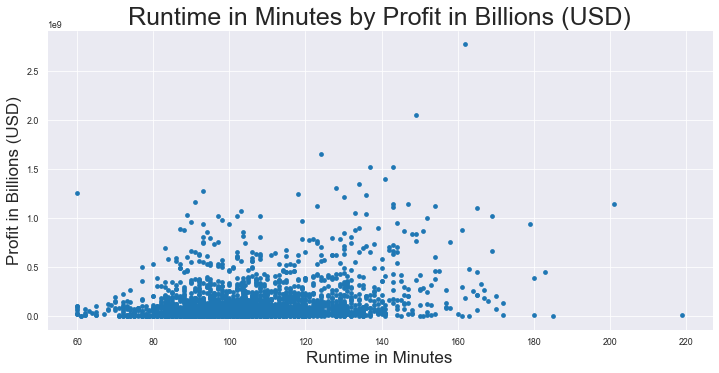

In [29]:
sns.relplot(x = 'runtimeMinutes',y = 'worldwide_gross', data = top_movies, height =5 , aspect=2, palette='BuGn_r', linewidth=0)
plt.xlabel('Runtime in Minutes', size=17)
plt.ylabel('Profit in Billions (USD)', size=17)
plt.title('Runtime in Minutes by Profit in Billions (USD)', size=25)

Text(0.5, 1, 'Profit Compared to Production Budget')

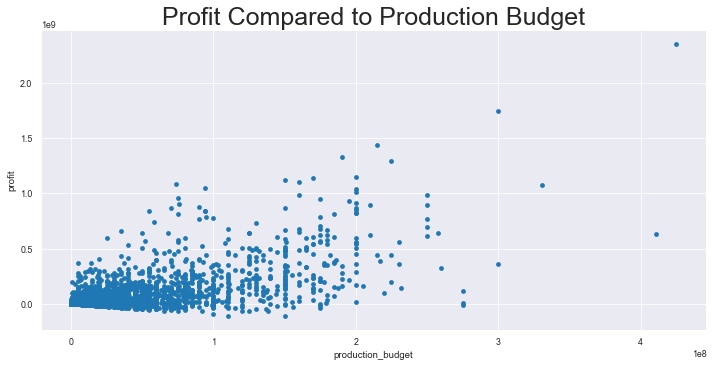

In [30]:
sns.relplot(x = 'production_budget',y = 'profit', data = top_movies, height =5 , aspect=2, palette='BuGn_r', linewidth=0)
plt.title('Profit Compared to Production Budget', size=25)

- changed top_movies df to df for typing ease
- changed release_date column back to datetime for datetime analysis
- split out year column to help with next visualization

In [31]:
df=top_movies
df['release_date'] = pd.to_datetime(df['release_date'])
df['releaseYear'] = df['release_date'].map(lambda x: x.year)

- grouped df by release year and summed all numeric columns, sliced out 2019 because box office info was incomplete
- plotted visualization through seaborn to show change of box office numbers over time
- plotted trendline to show positive correlation of time and box office growth
- annotated trendline to draw attention to starting and end points of y axis

0.39678611943528935

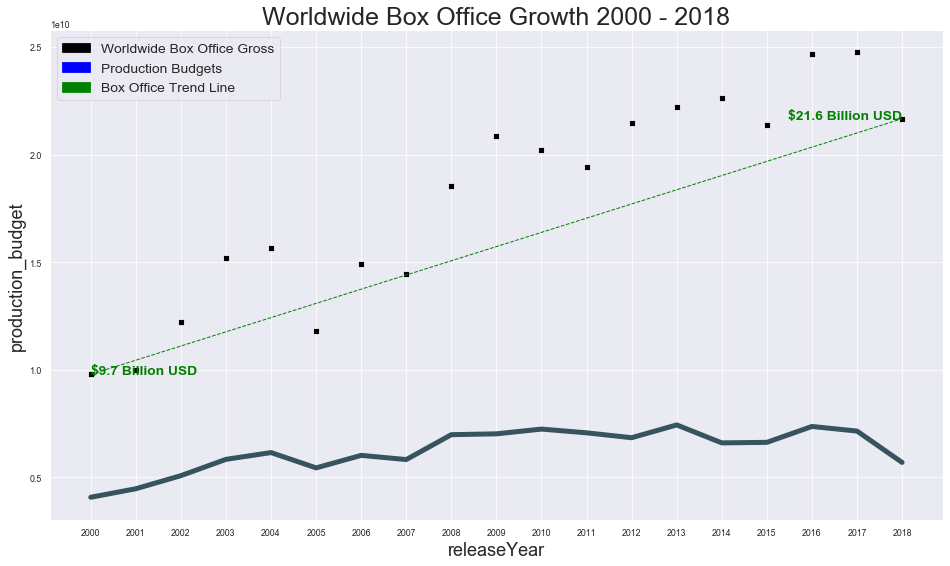

In [55]:
df20=df.groupby('releaseYear').sum().iloc[0:19]
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.scatterplot(data=df20, x=df20.index, y='worldwide_gross', color='k', marker='s', s=30)
ax1.set(xticks=df20.index)
ax1.text(2018, 2.166276e+10	, "$21.6 Billion USD", horizontalalignment='right', size='x-large', color='green', weight='semibold')
plt.title('Worldwide Box Office Growth 2000 - 2018', size=25)
plt.xlabel('Release Year', size=18)
plt.ylabel('Worldwide Box Office Gross in Tens of Billions (USD)', size=18)
ax2= plt.plot([2000, 2018], [9784484012, 21662756348], color='g', linestyle='--', linewidth=1)
ax1.text(2000, 9.784484e+09	, "$9.7 Billion USD", horizontalalignment='left', size='x-large', color='green', weight='semibold')
ax3=sns.lineplot(data=df20, x=df20.index, y='production_budget', linewidth=5)
black_patch = mpatches.Patch(color='k', label='Worldwide Box Office Gross')
blue_patch = mpatches.Patch(color='blue', label='Production Budgets')
green_patch = mpatches.Patch(color='green', label='Box Office Trend Line')
plt.legend(handles=[black_patch,blue_patch,green_patch], fontsize='x-large')
df20.astype('int')
(5695200000-4077360106)/4077360106

- grouped df by Genre and summed numeric columns, sliced out top 10 grossing genre pairs
- plotted worldwide gross and production budget on axes to show correlation between money spent and money earned
- imported matplotlib.patches library to create custom legends

,id,production_budget,domestic_gross,worldwide_gross,foreign_gross,runtimeMinutes,profit,releaseYear
Genre,,,,,,,,
Action/ Adventure,14159,31796100000,36420848760,99276037385,62855188625,33594,67479937385,589055
Adventure/ Animation,5221,9582000000,13668543268,36221892551,22553349283,10006,26639892551,223130
Comedy/ Drama,16600,6941399000,10337138345,18435817113,8098678768,34275,11494418113,666879
Action/ Drama,3739,4697030000,4275604721,10067277462,5791672741,9228,5370247462,156743
Biography/ Drama,6176,3511400000,5262035210,9604166304,4342131094,15608,6092766304,261338
Action/ Crime,6148,4756462000,4661583787,9058717376,4397133589,13352,4302255376,249114
Comedy/ Romance,6337,2888989000,4961931630,8623738943,3661807313,11411,5734749943,228890
Adventure/ Family,1161,2782900000,2646510778,7864416965,5217906187,2469,5081516965,42256
Action/ Comedy,4638,3504900000,4155822858,7299110865,3143288007,8370,3794210865,168744


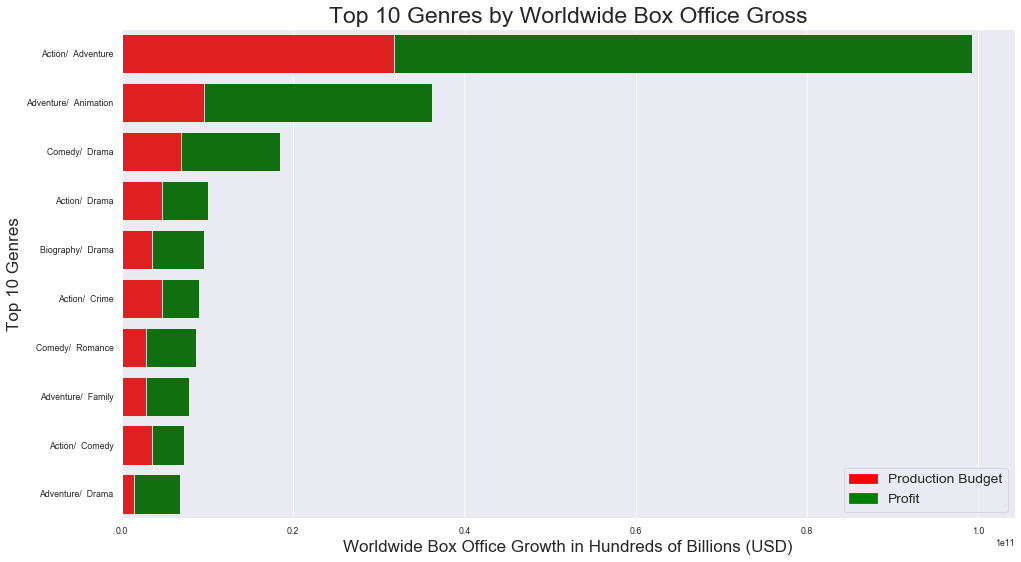

In [33]:
df10Genres=df.groupby('Genre').sum().sort_values('worldwide_gross', ascending=False).head(10)
df10Genres.astype('int')
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=df10Genres, x='worldwide_gross', y=df10Genres.index, color='g')
ax2=sns.barplot(data=df10Genres, x='production_budget', y=df10Genres.index, color='r')
plt.title('Top 10 Genres by Worldwide Box Office Gross', size=23)
plt.xlabel('Worldwide Box Office Growth in Hundreds of Billions (USD)', size=17)
plt.ylabel('Top 10 Genres', size=17)
red_patch = mpatches.Patch(color='red', label='Production Budget')
green_patch = mpatches.Patch(color='green', label='Profit')
plt.legend(handles=[red_patch,green_patch], fontsize='x-large')
df10Genres.astype('int')

- grouped df by Director and summed numeric values, sliced out top 20 directors
- plotted worldwide gross and production budget on axes to show correlation between money spent and money earned

0.16823401806951974

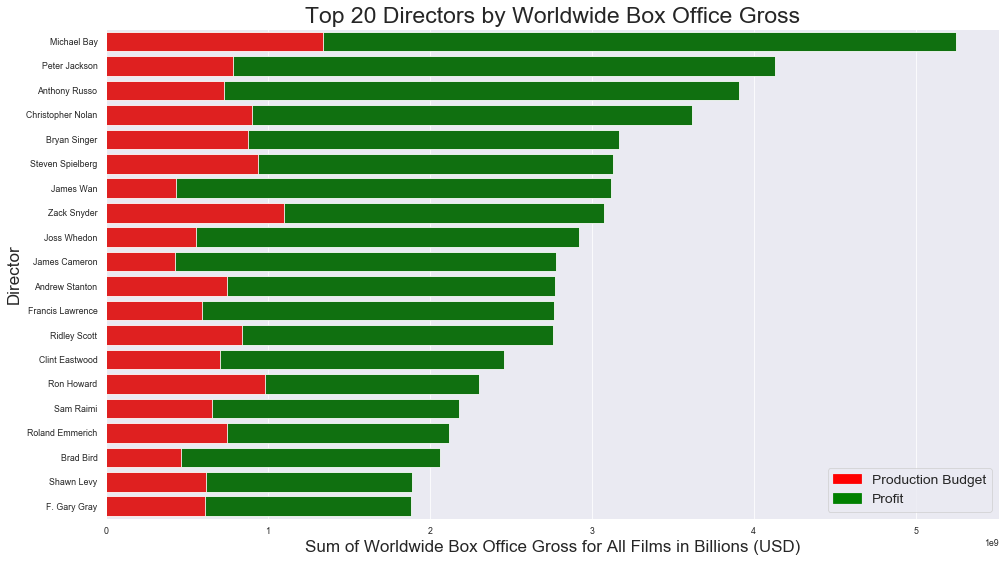

In [34]:
df100directors = df.groupby('Director').sum().sort_values('worldwide_gross', ascending=False).head(20)
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=df100directors, x='worldwide_gross', y=df100directors.index, color='g')
ax2=sns.barplot(data=df100directors, x='production_budget', y=df100directors.index, color='r')
plt.title("Top 20 Directors by Worldwide Box Office Gross", size=23)
plt.xlabel('Sum of Worldwide Box Office Gross for All Films in Billions (USD)', size=17)
plt.ylabel('Director', size=17)
red_patch = mpatches.Patch(color='red', label='Production Budget')
green_patch = mpatches.Patch(color='green', label='Profit')
plt.legend(handles=[red_patch,green_patch], fontsize='x-large')
df100directors['worldwide_gross'].sum()/df['worldwide_gross'].sum()

- grouped df by Writer and summed numeric values, sliced out top 20 writers
- plotted worldwide gross and production budget on axes to show correlation between money spent and money earned

Text(0, 0.5, 'Writer')

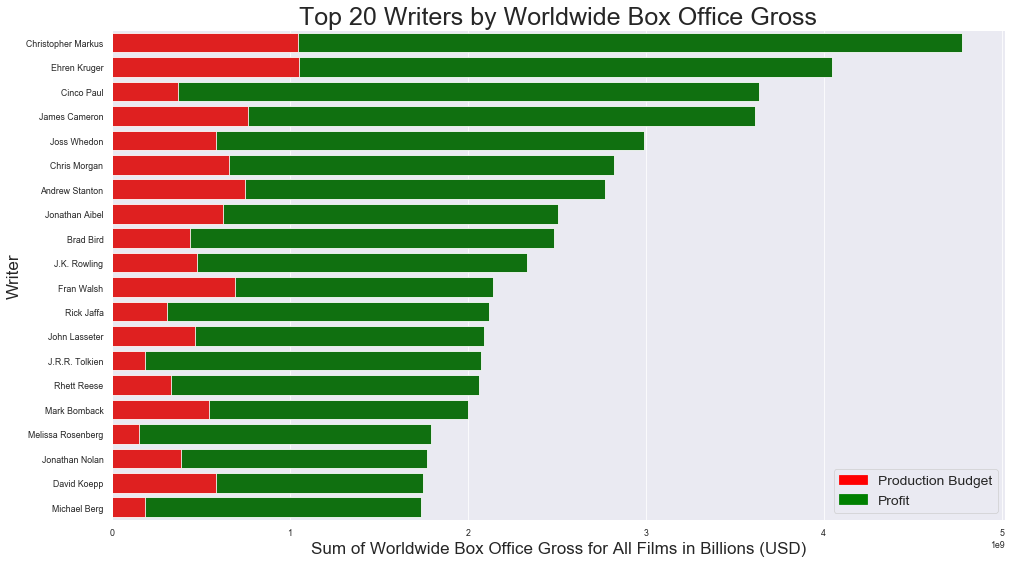

In [35]:
dfWriters= df.groupby('Writer').sum().sort_values('worldwide_gross', ascending=False).head(20)
fig, ax = plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=dfWriters, y=dfWriters.index, x='worldwide_gross', color='g')
ax2=sns.barplot(data=dfWriters, y=dfWriters.index, x='production_budget', color='r')
red_patch = mpatches.Patch(color='red', label='Production Budget')
green_patch = mpatches.Patch(color='green', label='Profit')
plt.legend(handles=[red_patch,green_patch], fontsize='x-large')
plt.title('Top 20 Writers by Worldwide Box Office Gross', size = 25)
plt.xlabel('Sum of Worldwide Box Office Gross for All Films in Billions (USD)', size=17)
plt.ylabel('Writer', size=17)

- grouped df by Director and averaged numeric values, sliced out top 20 directors
- plotted worldwide gross and production budget on axes to show correlation between money spent and money earned

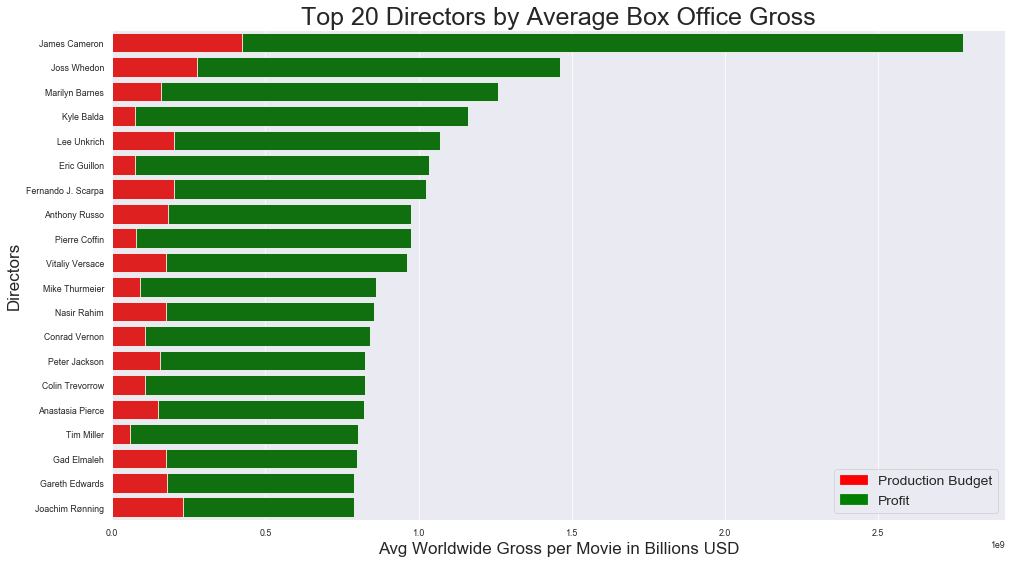

In [36]:
dfDirectorAVG=df.groupby('Director').mean().sort_values('worldwide_gross', ascending=False).head(20)
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=dfDirectorAVG, x='worldwide_gross', y=dfDirectorAVG.index, color='g')
ax2=sns.barplot(data=dfDirectorAVG, x='production_budget', y=dfDirectorAVG.index, color='r')
plt.title('Top 20 Directors by Average Box Office Gross', size=25)
plt.xlabel('Avg Worldwide Gross per Movie in Billions USD', size=17)
plt.ylabel('Directors', size =17)
red_patch = mpatches.Patch(color='red', label='Production Budget')
green_patch = mpatches.Patch(color='green', label='Profit')
plt.legend(handles=[red_patch,green_patch], fontsize='x-large')

- grouped df by Writer and averaged numeric values, sliced out top 20 writers
- plotted worldwide gross and production budget on axes to show correlation between money spent and money earned

Text(0, 0.5, 'Writers')

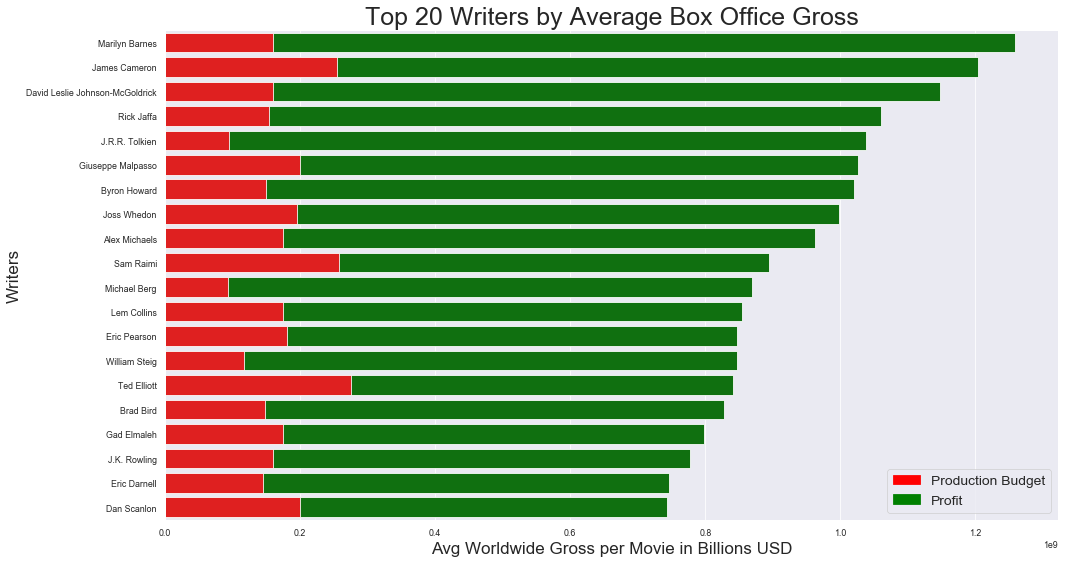

In [37]:
dfWriterAVG=df.groupby('Writer').mean().sort_values('worldwide_gross', ascending=False).head(20)
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=dfWriterAVG, x='worldwide_gross', y=dfWriterAVG.index, color='g')
ax2=sns.barplot(data=dfWriterAVG, x='production_budget', y=dfWriterAVG.index, color='r')
red_patch = mpatches.Patch(color='red', label='Production Budget')
green_patch = mpatches.Patch(color='green', label='Profit')
plt.legend(handles=[red_patch,green_patch], fontsize='x-large')
plt.title('Top 20 Writers by Average Box Office Gross', size=25)
plt.xlabel('Avg Worldwide Gross per Movie in Billions USD', size=17)
plt.ylabel('Writers', size =17)

- created new genre column to sort by later
- split out month from release_date column to sort by later
- split out action/adventure genre to compare against world wide gross numbers
- plot worldwide box office gross by month and action/adventure genre by month of different axes to compare on same plot

/Users/will4856/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/will4856/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


id  production_budget  domestic_gross  \
Genre              releaseMonth                                            
Action/  Adventure 1              716       1.008500e+09    6.204415e+08   
                   2              866       1.652000e+09    2.093846e+09   
                   3             1406       2.699850e+09    3.158813e+09   
                   4             1004       1.613750e+09    2.367991e+09   
                   5             1803       6.843200e+09    7.711462e+09   
                   6             1676       4.979500e+09    6.075882e+09   
                   7             1778       3.997800e+09    4.305742e+09   
                   8             1707       2.186500e+09    2.247764e+09   
                   9              676       7.575000e+08    5.593797e+08   
                   10             407       4.850000e+08    1.776983e+08   
                   11            1080       3.469000e+09    4.027025e+09   
                   12            1040       2.103500e+09    3.074803e+09   
Action/  Animation 2               41       8.000000e+07    1.757504e+08   
                   3                4       1.750000e+08    1.983515e+08   
                   6               59       3.800000e+07    7.392100e+07   
                   10              13       6.500000e+07    1.955107e+07   
                   11              47       1.300000e+08    1.484159e+08   
Action/  Biography 1               19       3.500000e+06    1.826950e+05   
                   6               81       5.000000e+07    2.081004e+07   
                   7               60       1.000000e+07    5.490423e+06   

                                 worldwide_gross  foreign_gross  \
Genre              releaseMonth                                   
Action/  Adventure 1                1.993945e+09   1.373503e+09   
                   2                5.045494e+09   2.951648e+09   
                   3                7.685901e+09   4.527088e+09   
                   4                7.949272e+09   5.581280e+09   
                   5                2.155190e+10   1.384043e+10   
                   6                1.637973e+10   1.030385e+10   
                   7                1.126092e+10   6.955173e+09   
                   8                5.259694e+09   3.011929e+09   
                   9                1.510925e+09   9.515452e+08   
                   10               6.508313e+08   4.731330e+08   
                   11               1.097065e+10   6.943623e+09   
                   12               9.016783e+09   5.941980e+09   
Action/  Animation 2                3.106600e+08   1.349096e+08   
                   3                3.816874e+08   1.833359e+08   
                   6                1.265779e+08   5.265687e+07   
                   10               4.163624e+07   2.208518e+07   
                   11               3.218872e+08   1.734714e+08   
Action/  Biography 1                1.826950e+05   0.000000e+00   
                   6                2.323725e+07   2.427216e+06   
                   7                7.037886e+06   1.547463e+06   

                                 runtimeMinutes        profit  releaseYear  \
Genre              releaseMonth                                              
Action/  Adventure 1                1698.000000  9.854448e+08        32207   
                   2                2127.000000  3.393494e+09        40220   
                   3                3016.000000  4.986051e+09        54304   
                   4                1836.549558  6.335522e+09        32201   
                   5                5059.000000  1.470870e+10        82471   
                   6                4255.000000  1.140023e+10        70365   
                   7                3993.000000  7.263115e+09        70330   
                   8                3144.000000  3.073194e+09        58261   
                   9                1421.000000  7.534249e+08        26142   
                   10        

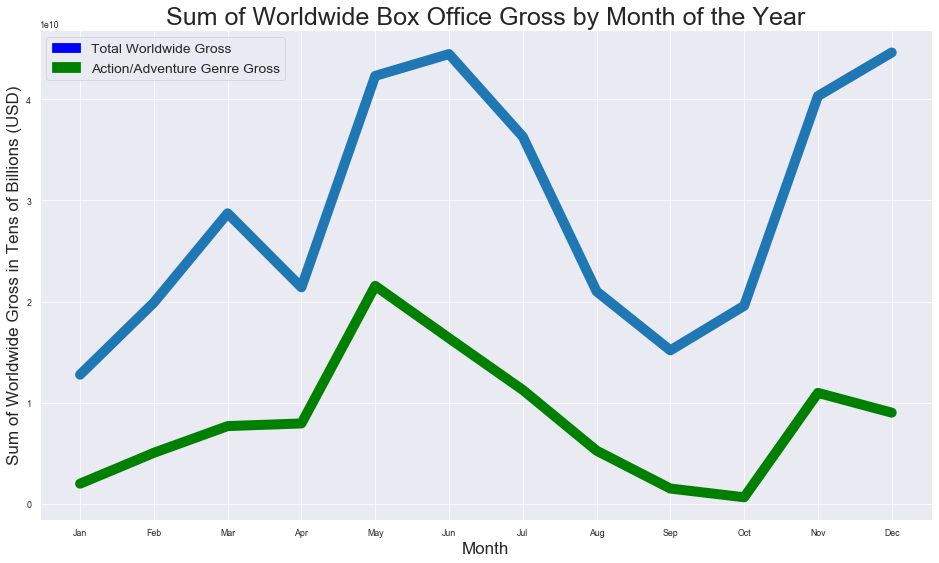

In [38]:
df['Genre1'] = df['Genre']
df['releaseMonth'] = df['release_date'].map(lambda x: x.month)
dfGenresMo=df.groupby(['Genre','releaseMonth']).sum()
dfGenresMo['GenreDupe'] = dfGenresMo.index
dfGenresMo['GenreDupe'] = dfGenresMo['GenreDupe'].map(lambda x: x[0])
dfAcAd=dfGenresMo.head(12)
dfAcAd['rmdupe'] = dfAcAd.index
dfAcAd['rmdupe'] = dfAcAd['rmdupe'].map(lambda x: x[1])
dfMonths=df.groupby('releaseMonth').sum().sort_values('worldwide_gross',ascending=False)
dfMonths['releaseMonth1'] = dfMonths.index
dfMonths=dfMonths.sort_values('releaseMonth1')
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.lineplot(data=dfMonths,x='releaseMonth1', y='worldwide_gross', linewidth=10)
ax1.set(xticks=dfMonths.index)
ax.set(xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax2=sns.lineplot(data=dfAcAd, x='rmdupe', y='worldwide_gross', color = 'g', linewidth=10)
plt.ylabel('Sum of Worldwide Gross in Tens of Billions (USD)', size=17)
plt.xlabel('Month', size=17)
plt.title('Sum of Worldwide Box Office Gross by Month of the Year', size=25)
blue_patch = mpatches.Patch(color='blue', label='Total Worldwide Gross')
green_patch = mpatches.Patch(color='green', label='Action/Adventure Genre Gross')
plt.legend(handles=[blue_patch,green_patch], fontsize='x-large')
dfGenresMo.head(20)

- wrote function to quickly plot multiple career timelines on same plot for writers and directors
- used function to plot 10 writers and 10 directors at a time 

In [39]:
def makeplot(names):
    for x in names:
        plot = sns.lineplot(data=df.loc[df.Director == x].sort_values('release_date'), x='release_date', y='profit', linewidth=5)
    return plot

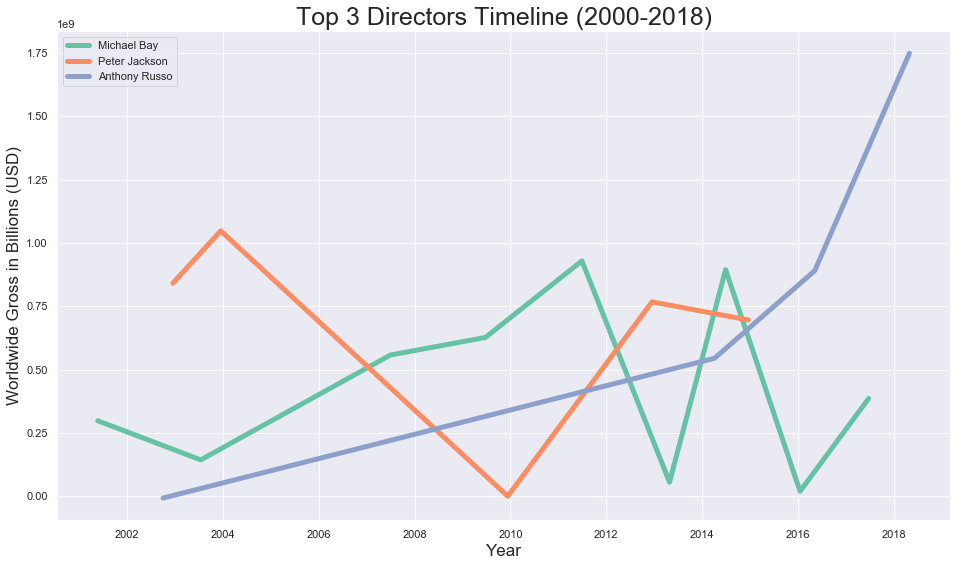

In [82]:
df100direct=list(df100directors.index[0:3])
fig,ax=plt.subplots(figsize=(16,9))
ax1=makeplot(df100direct)
#ax1.set(xticks=range(0:19))
plt.title('Top 3 Directors Timeline (2000-2018)', size=25)
plt.xlabel('Year', size=17)
plt.ylabel('Worldwide Gross in Billions (USD)', size=17)
ax1.legend(df100direct)
sns.set_palette("Set2")

In [77]:
def makeplot_write(names):
    for x in names:
        plot = sns.lineplot(data=df.loc[df.Writer == x].sort_values('release_date'), x='release_date', y='worldwide_gross', linewidth=5)
    return plot

In [86]:
dfwrite= list(dfWriters.index[0:4])
dfwrite

['Christopher Markus', 'Ehren Kruger', 'Cinco Paul', 'James Cameron']

Text(0, 0.5, 'Worldwide Gross in Billions (USD)')

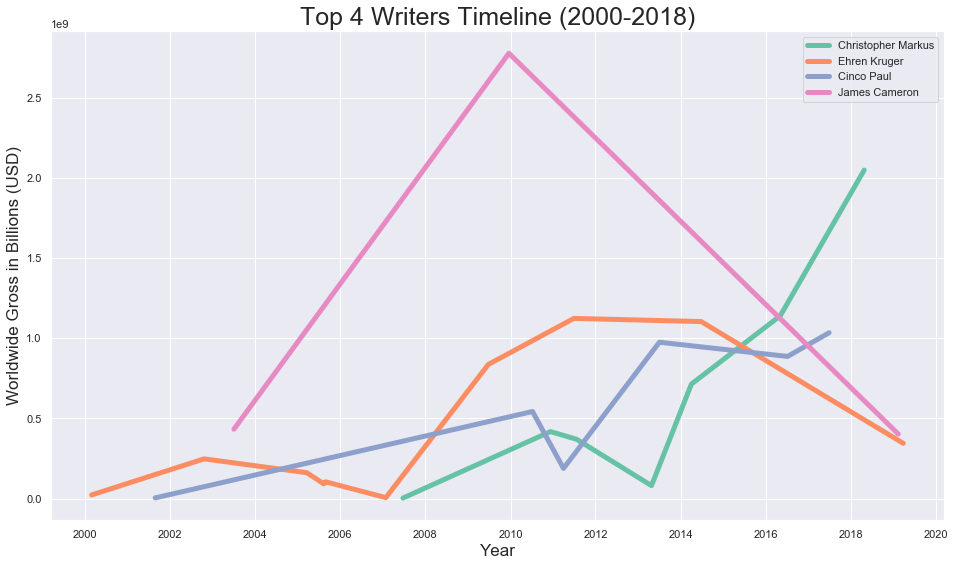

In [88]:
fig,ax=plt.subplots(figsize=(16,9))
ax1=makeplot_write(dfwrite)
plt.legend(dfwrite)
plt.title('Top 4 Writers Timeline (2000-2018)', size=25)
plt.xlabel('Year', size=17)
plt.ylabel('Worldwide Gross in Billions (USD)', size=17)

-0.024793388429752067

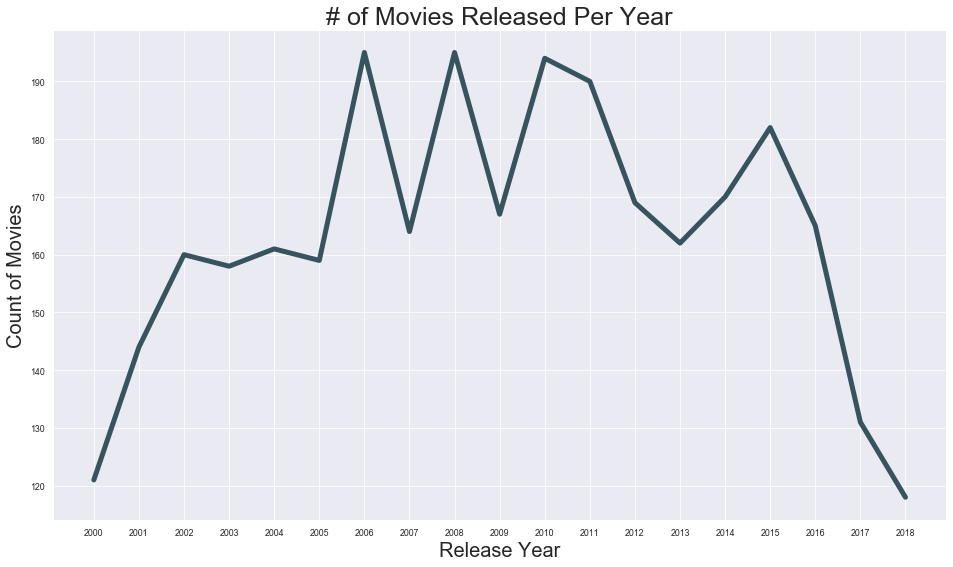

In [53]:
dfmoviecount = df.groupby('releaseYear').count().head(19)
fig,ax=plt.subplots(figsize=(16,9))
ax1=sns.lineplot(data=dfmoviecount, x=dfmoviecount.index, y='id', linewidth=5)
ax1.set(xticks=dfmoviecount.index)
plt.title('# of Movies Released Per Year', size=25)
plt.ylabel('Count of Movies', size = 20)
plt.xlabel('Release Year', size=20)
dfmoviecount.astype('int')
(118-121)/121




0.43229764855763936

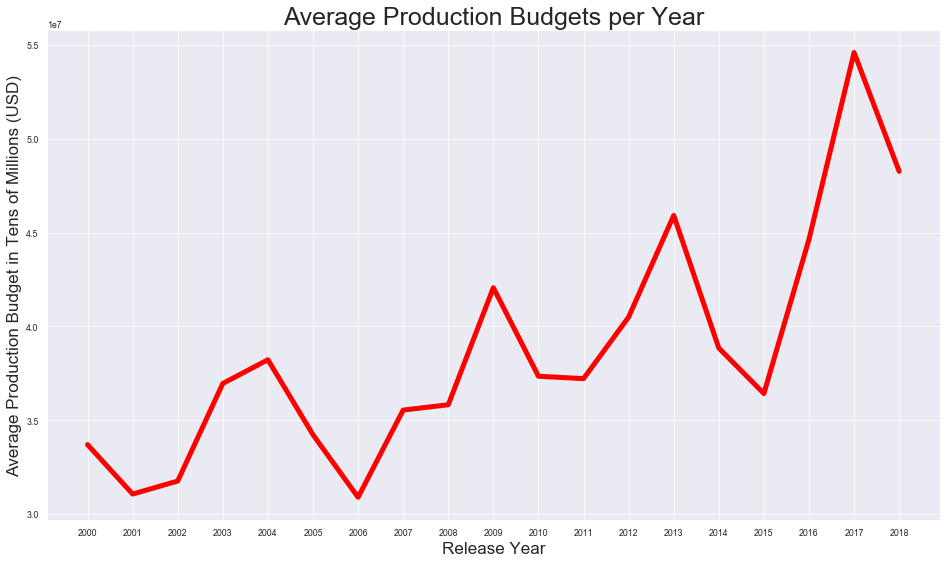

In [51]:
df20AVG=df.groupby('releaseYear').mean().head(19)
fig,ax=plt.subplots(figsize=(16,9))
ax1=sns.lineplot(data=df20AVG, x=df20AVG.index, y='production_budget', color='r', linewidth=5)
ax1.set(xticks=df20AVG.index)
plt.title('Average Production Budgets per Year', size=25)
plt.xlabel('Release Year', size=17)
plt.ylabel('Average Production Budget in Tens of Millions (USD)', size=17)
df20AVG.astype('int')
(48264406 - 33697190)/33697190

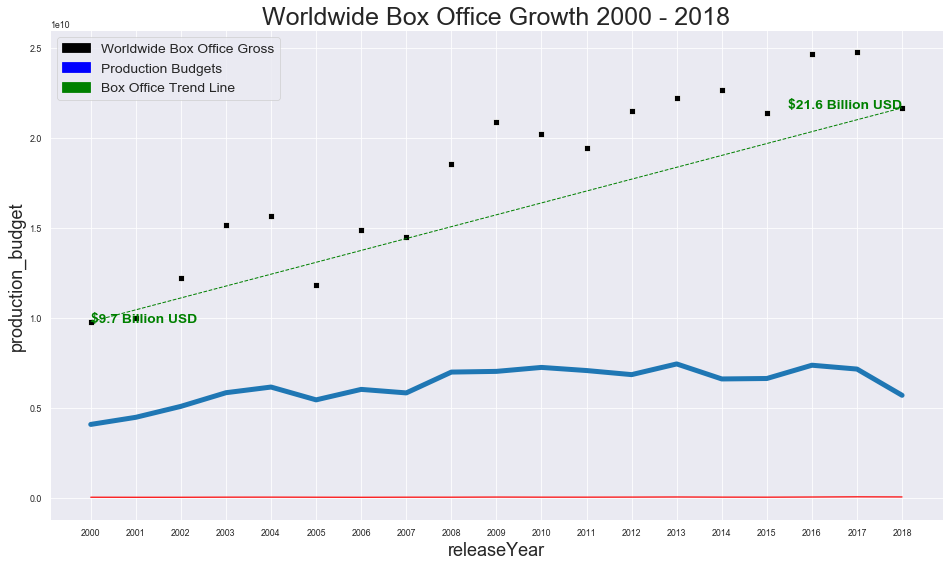

In [46]:
df20=df.groupby('releaseYear').sum().iloc[0:19]
fig,ax = plt.subplots(figsize=(16,9))
ax1=sns.scatterplot(data=df20, x=df20.index, y='worldwide_gross', color='k', marker='s', s=30)
ax1.set(xticks=df20.index)
ax1.text(2018, 2.166276e+10	, "$21.6 Billion USD", horizontalalignment='right', size='x-large', color='green', weight='semibold')
plt.title('Worldwide Box Office Growth 2000 - 2018', size=25)
plt.xlabel('Release Year', size=18)
plt.ylabel('Worldwide Box Office Gross in Tens of Billions (USD)', size=18)
ax2= plt.plot([2000, 2018], [9784484012, 21662756348], color='g', linestyle='--', linewidth=1)
ax1.text(2000, 9.784484e+09	, "$9.7 Billion USD", horizontalalignment='left', size='x-large', color='green', weight='semibold')
ax3=sns.lineplot(data=df20, x=df20.index, y='production_budget', linewidth=5)
black_patch = mpatches.Patch(color='k', label='Worldwide Box Office Gross')
blue_patch = mpatches.Patch(color='blue', label='Production Budgets')
green_patch = mpatches.Patch(color='green', label='Box Office Trend Line')
plt.legend(handles=[black_patch,blue_patch,green_patch], fontsize='x-large')
ax4=sns.lineplot(data=df20AVG, x=df20AVG.index, y='production_budget', color='r')

In [47]:
df20AVG.astype('int')

,id,production_budget,domestic_gross,worldwide_gross,foreign_gross,runtimeMinutes,profit,releaseMonth
releaseYear,,,,,,,,
2000,49,33697190,46327585,80863504,34535918,105,47166313,7
2001,49,31061180,40458404,69442590,28984185,104,38381409,7
2002,50,31755860,42533241,76265084,33731842,102,44509224,7
2003,45,36956348,49473741,96048691,46574949,105,59092343,6
2004,50,38221086,50421042,97243396,46822353,104,59022309,6
2005,50,34224925,38057799,74207018,36149219,103,39982093,6
2006,47,30890984,37681302,76409124,38727822,103,45518140,6
2007,50,35538957,41560450,88194961,46634511,105,52656004,7
2008,52,35821841,42811032,95039675,52228643,102,59217834,7


Text(0, 0.5, 'Movie, Director')

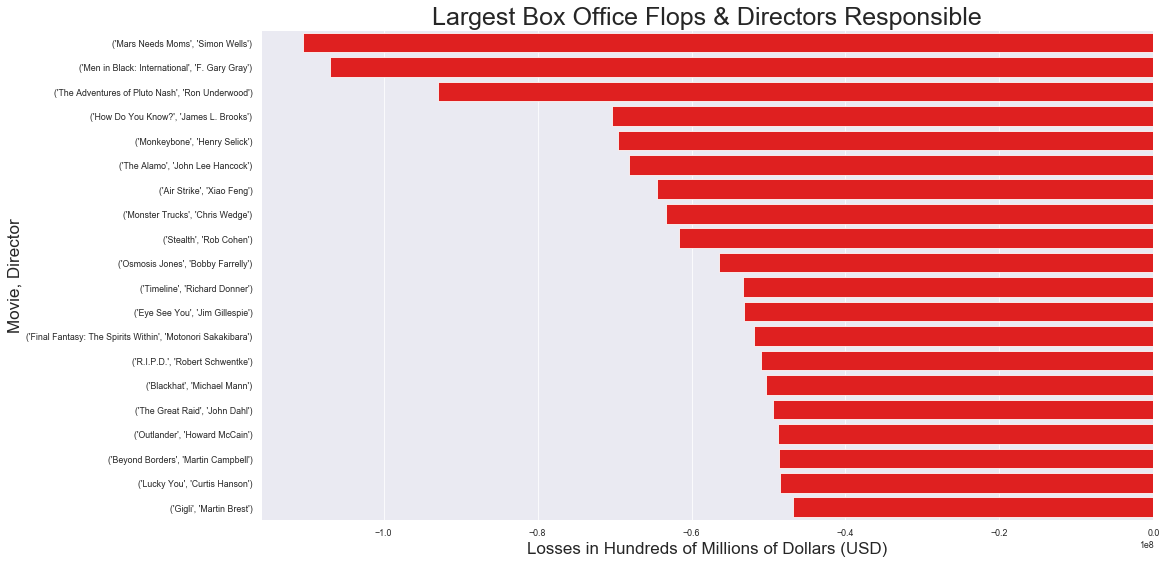

In [63]:
dfFlops=df.groupby(['title','Director']).sum().sort_values('profit').head(20)
fig,ax=plt.subplots(figsize=(16,9))
ax1=sns.barplot(data=dfFlops, y=dfFlops.index, x='profit', color='r')
plt.title('Largest Box Office Flops & Directors Responsible', size=25)
plt.xlabel('Losses in Hundreds of Millions of Dollars (USD)', size=17)
plt.ylabel('Movie, Director', size=17)
sns.set_palette("GnBu_d")

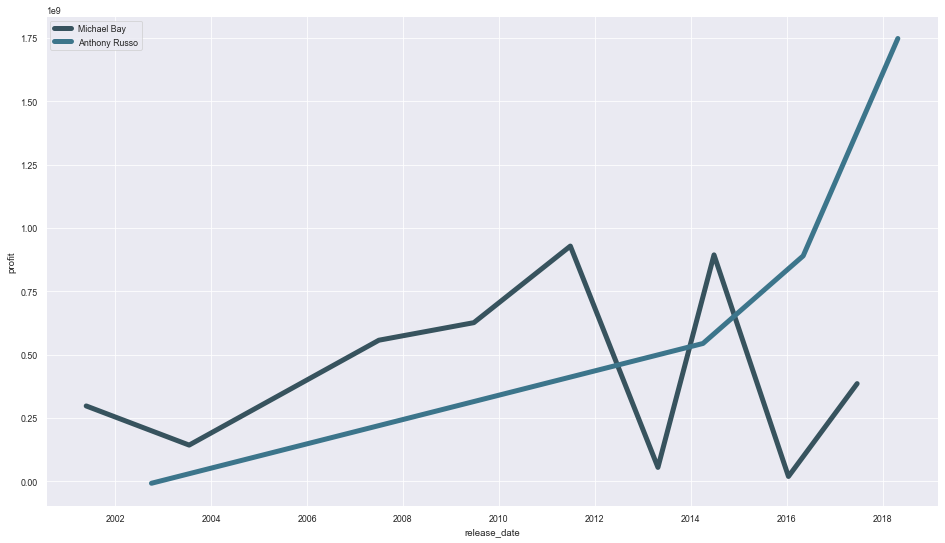

In [59]:
fig,ax=plt.subplots(figsize=(16,9))
makeplot(['Michael Bay', 'Anthony Russo'])
plt.legend(['Michael Bay', 'Anthony Russo'])